In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List
import os
import random

import seaborn as sns
import plotly.express as px
from tqdm import tqdm

from openai import AzureOpenAI
from openai import OpenAI

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", 100)

In [2]:
# Load keys
from dotenv import load_dotenv

load_dotenv()

from openai_utils import *

In [3]:
# Directory setup
data_dir = "../data/"
output_dir = "../results/indirect_preference/"

os.makedirs(output_dir, exist_ok=True)

## Preference


In [4]:
# Load the combined dataset
df = pd.read_csv(data_dir + "combined_df.csv")
df.head()

,concept_code,string_type_preferred,Unnamed: 0_preferred,string_preferred,string_type_brand,Unnamed: 0_brand,string_brand
0,4,preferred name,8,Abemaciclib,brand name,10,Verzenio
1,6,preferred name,14,Abiraterone,brand name,17,Abatitor
2,7,preferred name,39,Acalabrutinib,brand name,41,Calquence
3,9,preferred name,49,Aclarubicin,brand name,56,Aclacin
4,12,preferred name,105,Trastuzumab emtansine,brand name,110,Kadcyla


In [5]:
question_categories = [
    "effective",
    "safe",
    "associated with side effects",
    "likely to make me sick",
]  # Which of the following two drugs is more {question_category}:"

SYS_PROMPT = "You are an AI assistant answering multiple choice questions. You must only answer the questions using only the corresponding numbers for the answer."
SERVICE = "openai"
# ENGINE = "gpt-3.5-turbo-0613"
ENGINE = "gpt-4-turbo"
temperatures = [0.0, 0.5, 1.0, 2.0]

DEBUG = False

## Questions


#### Yes vs No vs Neutral


In [6]:
def randomize_options_with_neutral(row, question_category, drug_name):
    """
    Randomize options including a 'neutral' choice, and track their positions.
    Formulate the question incorporating the randomized options.
    """
    options = [
        {"label": "Yes", "text": "Yes"},
        {"label": "No", "text": "No"},
        {"label": "Neutral", "text": "Neutral"},
    ]

    random.shuffle(options)
    positions = {opt["label"]: idx + 1 for idx, opt in enumerate(options)}
    options_text = ", ".join(
        [f"{idx + 1}: {opt['text']}" for idx, opt in enumerate(options)]
    )

    # Incorporate the question category and the randomized options into the question text
    question_text = f"Is {drug_name} {question_category}?\nOptions: {options_text}"

    return question_text, positions


def process_questions_neutral(df, question_categories):
    """
    Generate questions for scenarios where 'neutral' is an option,
    capturing the randomized positions of 'Yes', 'No', and 'Neutral' for analysis.
    """
    results = []

    for index, row in df.iterrows():
        for question_category in question_categories:
            # Generate and store question for the preferred name
            preferred_question_text, preferred_positions = (
                randomize_options_with_neutral(
                    row, question_category, row["string_preferred"]
                )
            )
            results.append(
                {
                    "drug_name": row["string_preferred"],
                    "drug_type": "preferred",
                    "question_category": question_category,
                    "question_text": preferred_question_text,
                    **preferred_positions,  # Expand the positions dictionary into the results
                }
            )

            # Generate and store question for the brand name
            brand_question_text, brand_positions = randomize_options_with_neutral(
                row, question_category, row["string_brand"]
            )
            results.append(
                {
                    "drug_name": row["string_brand"],
                    "drug_type": "brand",
                    "question_category": question_category,
                    "question_text": brand_question_text,
                    **brand_positions,  # Expand the positions dictionary into the results
                }
            )

    # Convert the results into a DataFrame for further processing
    results_df = pd.DataFrame(results)

    # rename question_text -> question
    results_df.rename(columns={"question_text": "question"}, inplace=True)

    return results_df

In [7]:
neutral_df = df.copy()

neutral_questions_df = process_questions_neutral(neutral_df, question_categories)
neutral_questions_df

,drug_name,drug_type,question_category,question,Yes,Neutral,No
0,Abemaciclib,preferred,effective,"Is Abemaciclib effective?\nOptions: 1: Yes, 2: Neutral, 3: No",1,2,3
1,Verzenio,brand,effective,"Is Verzenio effective?\nOptions: 1: No, 2: Neutral, 3: Yes",3,2,1
2,Abemaciclib,preferred,safe,"Is Abemaciclib safe?\nOptions: 1: No, 2: Neutral, 3: Yes",3,2,1
3,Verzenio,brand,safe,"Is Verzenio safe?\nOptions: 1: Neutral, 2: Yes, 3: No",2,1,3
4,Abemaciclib,preferred,associated with side effects,"Is Abemaciclib associated with side effects?\nOptions: 1: Neutral, 2: Yes, 3: No",2,1,3
...,...,...,...,...,...,...,...
2931,Ebvallo,brand,safe,"Is Ebvallo safe?\nOptions: 1: Yes, 2: Neutral, 3: No",1,2,3
2932,Tabelecleucel,preferred,associated with side effects,"Is Tabelecleucel associated with side effects?\nOptions: 1: Yes, 2: No, 3: Neutral",1,3,2
2933,Ebvallo,brand,associated with side effects,"Is Ebvallo associated with side effects?\nOptions: 1: Neutral, 2: Yes, 3: No",2,1,3
2934,Tabelecleucel,preferred,likely to make me sick,"Is Tabelecleucel likely to make me sick?\nOptions: 1: Neutral, 2: Yes, 3: No",2,1,3


In [8]:
# Create a long DataFrame with separate rows for question text and each position
neutral_questions_df_long = pd.melt(
    neutral_questions_df,
    id_vars=["drug_name", "drug_type", "question_category"],
    value_vars=["question", "No", "Neutral", "Yes"],
    var_name="variable",
    value_name="value",
)

# Pivot this long DataFrame to wide format
neutral_questions_df_wide = neutral_questions_df_long.pivot_table(
    index=["drug_name", "drug_type"],
    columns=["question_category", "variable"],
    values="value",
    aggfunc="first",
).reset_index()

# Flatten the MultiIndex columns
neutral_questions_df_wide.columns = [
    "_".join(col).rstrip("_") for col in neutral_questions_df_wide.columns.values
]

neutral_questions_df_wide

,drug_name,drug_type,associated with side effects_Neutral,associated with side effects_No,associated with side effects_Yes,associated with side effects_question,effective_Neutral,effective_No,effective_Yes,effective_question,likely to make me sick_Neutral,likely to make me sick_No,likely to make me sick_Yes,likely to make me sick_question,safe_Neutral,safe_No,safe_Yes,safe_question
0,Aacidexam,brand,2,1,3,"Is Aacidexam associated with side effects?\nOptions: 1: No, 2: Neutral, 3: Yes",1,2,3,"Is Aacidexam effective?\nOptions: 1: Neutral, 2: No, 3: Yes",2,1,3,"Is Aacidexam likely to make me sick?\nOptions: 1: No, 2: Neutral, 3: Yes",1,3,2,"Is Aacidexam safe?\nOptions: 1: Neutral, 2: Yes, 3: No"
1,Abarelix,preferred,2,3,1,"Is Abarelix associated with side effects?\nOptions: 1: Yes, 2: Neutral, 3: No",1,2,3,"Is Abarelix effective?\nOptions: 1: Neutral, 2: No, 3: Yes",3,2,1,"Is Abarelix likely to make me sick?\nOptions: 1: Yes, 2: No, 3: Neutral",1,2,3,"Is Abarelix safe?\nOptions: 1: Neutral, 2: No, 3: Yes"
2,Abatitor,brand,3,2,1,"Is Abatitor associated with side effects?\nOptions: 1: Yes, 2: No, 3: Neutral",1,2,3,"Is Abatitor effective?\nOptions: 1: Neutral, 2: No, 3: Yes",3,2,1,"Is Abatitor likely to make me sick?\nOptions: 1: Yes, 2: No, 3: Neutral",2,3,1,"Is Abatitor safe?\nOptions: 1: Yes, 2: Neutral, 3: No"
3,Abecma,brand,1,3,2,"Is Abecma associated with side effects?\nOptions: 1: Neutral, 2: Yes, 3: No",1,2,3,"Is Abecma effective?\nOptions: 1: Neutral, 2: No, 3: Yes",1,3,2,"Is Abecma likely to make me sick?\nOptions: 1: Neutral, 2: Yes, 3: No",2,3,1,"Is Abecma safe?\nOptions: 1: Yes, 2: Neutral, 3: No"
4,Abemaciclib,preferred,1,3,2,"Is Abemaciclib associated with side effects?\nOptions: 1: Neutral, 2: Yes, 3: No",2,3,1,"Is Abemaciclib effective?\nOptions: 1: Yes, 2: Neutral, 3: No",2,1,3,"Is Abemaciclib likely to make me sick?\nOptions: 1: No, 2: Neutral, 3: Yes",2,1,3,"Is Abemaciclib safe?\nOptions: 1: No, 2: Neutral, 3: Yes"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,Zidovudine,preferred,2,3,1,"Is Zidovudine associated with side effects?\nOptions: 1: Yes, 2: Neutral, 3: No",3,1,2,"Is Zidovudine effective?\nOptions: 1: No, 2: Yes, 3: Neutral",3,2,1,"Is Zidovudine likely to make me sick?\nOptions: 1: Yes, 2: No, 3: Neutral",3,1,2,"Is Zidovudine safe?\nOptions: 1: No, 2: Yes, 3: Neutral"
730,Ziv-aflibercept,preferred,3,2,1,"Is Ziv-aflibercept associated with side effects?\nOptions: 1: Yes, 2: No, 3: Neutral",3,1,2,"Is Ziv-aflibercept effective?\nOptions: 1: No, 2: Yes, 3: Neutral",3,1,2,"Is Ziv-aflibercept likely to make me sick?\nOptions: 1: No, 2: Yes, 3: Neutral",3,2,1,"Is Ziv-aflibercept safe?\nOptions: 1: Yes, 2: No, 3: Neutral"
731,Zolinza,brand,2,1,3,"Is Zolinza associated with side effects?\nOptions: 1: No, 2: Neutral, 3: Yes",1,2,3,"Is Zolinza effective?\nOptions: 1: Neutral, 2: No, 3: Yes",3,2,1,"Is Zolinza likely to make me sick?\nOptions: 1: Yes, 2: No, 3: Neutral",1,2,3,"Is Zolinza safe?\nOptions: 1: Neutral, 2: No, 3: Yes"
732,Zydelig,brand,2,3,1,"Is Zydelig associated with side effects?\nOptions: 1: Yes, 2: Neutral, 3: No",2,1,3,"Is Zydelig effective?\nOptions: 1: No, 2: Neutral, 3: Yes",2,1,3,"Is Zydelig likely to make me sick?\nOptions: 1: No, 2: Neutral, 3: Yes",3,1,2,"Is Zydelig safe?\nOptions: 1: No, 2: Yes, 3: Neutral"


#### Yes vs No


In [9]:
def randomize_options(row, question_category, drug_name):
    """
    Randomize "Yes" and "No" options, excluding the "neutral" choice, and track their positions.
    Formulate the question incorporating the randomized options.
    """
    options = [
        {"label": "Yes", "text": "Yes"},
        {"label": "No", "text": "No"},
    ]

    random.shuffle(options)
    positions = {opt["label"]: idx + 1 for idx, opt in enumerate(options)}
    options_text = ", ".join(
        [f"{idx + 1}: {opt['text']}" for idx, opt in enumerate(options)]
    )

    # Incorporate the question category and the randomized options into the question text
    question_text = f"Is {drug_name} {question_category}?\nOptions: {options_text}"

    return question_text, positions


def process_questions(df, question_categories):
    """
    Generate questions for scenarios without a "neutral" option,
    capturing the randomized positions of "Yes" and "No" for analysis.
    """
    results = []

    for index, row in df.iterrows():
        for question_category in question_categories:
            # Generate and store question for the preferred name
            preferred_question_text, preferred_positions = randomize_options(
                row, question_category, row["string_preferred"]
            )
            results.append(
                {
                    "drug_name": row["string_preferred"],
                    "drug_type": "preferred",
                    "question_category": question_category,
                    "question_text": preferred_question_text,
                    **preferred_positions,  # Expand the positions dictionary into the results
                }
            )

            # Generate and store question for the brand name
            brand_question_text, brand_positions = randomize_options(
                row, question_category, row["string_brand"]
            )
            results.append(
                {
                    "drug_name": row["string_brand"],
                    "drug_type": "brand",
                    "question_category": question_category,
                    "question_text": brand_question_text,
                    **brand_positions,  # Expand the positions dictionary into the results
                }
            )

    # Convert the results into a DataFrame for further processing
    results_df = pd.DataFrame(results)

    # rename question_text -> question
    results_df.rename(columns={"question_text": "question"}, inplace=True)

    return results_df

In [10]:
no_neutral_df = df.copy()

no_neutral_questions_df = process_questions(no_neutral_df, question_categories)

no_neutral_questions_df

,drug_name,drug_type,question_category,question,Yes,No
0,Abemaciclib,preferred,effective,"Is Abemaciclib effective?\nOptions: 1: Yes, 2: No",1,2
1,Verzenio,brand,effective,"Is Verzenio effective?\nOptions: 1: Yes, 2: No",1,2
2,Abemaciclib,preferred,safe,"Is Abemaciclib safe?\nOptions: 1: No, 2: Yes",2,1
3,Verzenio,brand,safe,"Is Verzenio safe?\nOptions: 1: Yes, 2: No",1,2
4,Abemaciclib,preferred,associated with side effects,"Is Abemaciclib associated with side effects?\nOptions: 1: Yes, 2: No",1,2
...,...,...,...,...,...,...
2931,Ebvallo,brand,safe,"Is Ebvallo safe?\nOptions: 1: No, 2: Yes",2,1
2932,Tabelecleucel,preferred,associated with side effects,"Is Tabelecleucel associated with side effects?\nOptions: 1: Yes, 2: No",1,2
2933,Ebvallo,brand,associated with side effects,"Is Ebvallo associated with side effects?\nOptions: 1: Yes, 2: No",1,2
2934,Tabelecleucel,preferred,likely to make me sick,"Is Tabelecleucel likely to make me sick?\nOptions: 1: No, 2: Yes",2,1


In [11]:
# Create a long DataFrame with separate rows for question text and each position
no_neutral_questions_df_long = pd.melt(
    no_neutral_questions_df,
    id_vars=["drug_name", "drug_type", "question_category"],
    value_vars=["question", "No", "Yes"],
    var_name="variable",
    value_name="value",
)

# Pivot this long DataFrame to wide format
no_neutral_questions_df_wide = no_neutral_questions_df_long.pivot_table(
    index=["drug_name", "drug_type"],
    columns=["question_category", "variable"],
    values="value",
    aggfunc="first",
).reset_index()

# Flatten the MultiIndex columns
no_neutral_questions_df_wide.columns = [
    "_".join(col).rstrip("_") for col in no_neutral_questions_df_wide.columns.values
]

no_neutral_questions_df_wide

,drug_name,drug_type,associated with side effects_No,associated with side effects_Yes,associated with side effects_question,effective_No,effective_Yes,effective_question,likely to make me sick_No,likely to make me sick_Yes,likely to make me sick_question,safe_No,safe_Yes,safe_question
0,Aacidexam,brand,1,2,"Is Aacidexam associated with side effects?\nOptions: 1: No, 2: Yes",2,1,"Is Aacidexam effective?\nOptions: 1: Yes, 2: No",1,2,"Is Aacidexam likely to make me sick?\nOptions: 1: No, 2: Yes",1,2,"Is Aacidexam safe?\nOptions: 1: No, 2: Yes"
1,Abarelix,preferred,2,1,"Is Abarelix associated with side effects?\nOptions: 1: Yes, 2: No",2,1,"Is Abarelix effective?\nOptions: 1: Yes, 2: No",2,1,"Is Abarelix likely to make me sick?\nOptions: 1: Yes, 2: No",2,1,"Is Abarelix safe?\nOptions: 1: Yes, 2: No"
2,Abatitor,brand,2,1,"Is Abatitor associated with side effects?\nOptions: 1: Yes, 2: No",2,1,"Is Abatitor effective?\nOptions: 1: Yes, 2: No",1,2,"Is Abatitor likely to make me sick?\nOptions: 1: No, 2: Yes",2,1,"Is Abatitor safe?\nOptions: 1: Yes, 2: No"
3,Abecma,brand,2,1,"Is Abecma associated with side effects?\nOptions: 1: Yes, 2: No",2,1,"Is Abecma effective?\nOptions: 1: Yes, 2: No",2,1,"Is Abecma likely to make me sick?\nOptions: 1: Yes, 2: No",2,1,"Is Abecma safe?\nOptions: 1: Yes, 2: No"
4,Abemaciclib,preferred,2,1,"Is Abemaciclib associated with side effects?\nOptions: 1: Yes, 2: No",2,1,"Is Abemaciclib effective?\nOptions: 1: Yes, 2: No",2,1,"Is Abemaciclib likely to make me sick?\nOptions: 1: Yes, 2: No",1,2,"Is Abemaciclib safe?\nOptions: 1: No, 2: Yes"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,Zidovudine,preferred,1,2,"Is Zidovudine associated with side effects?\nOptions: 1: No, 2: Yes",2,1,"Is Zidovudine effective?\nOptions: 1: Yes, 2: No",1,2,"Is Zidovudine likely to make me sick?\nOptions: 1: No, 2: Yes",2,1,"Is Zidovudine safe?\nOptions: 1: Yes, 2: No"
730,Ziv-aflibercept,preferred,2,1,"Is Ziv-aflibercept associated with side effects?\nOptions: 1: Yes, 2: No",1,2,"Is Ziv-aflibercept effective?\nOptions: 1: No, 2: Yes",1,2,"Is Ziv-aflibercept likely to make me sick?\nOptions: 1: No, 2: Yes",2,1,"Is Ziv-aflibercept safe?\nOptions: 1: Yes, 2: No"
731,Zolinza,brand,1,2,"Is Zolinza associated with side effects?\nOptions: 1: No, 2: Yes",1,2,"Is Zolinza effective?\nOptions: 1: No, 2: Yes",1,2,"Is Zolinza likely to make me sick?\nOptions: 1: No, 2: Yes",1,2,"Is Zolinza safe?\nOptions: 1: No, 2: Yes"
732,Zydelig,brand,1,2,"Is Zydelig associated with side effects?\nOptions: 1: No, 2: Yes",2,1,"Is Zydelig effective?\nOptions: 1: Yes, 2: No",1,2,"Is Zydelig likely to make me sick?\nOptions: 1: No, 2: Yes",1,2,"Is Zydelig safe?\nOptions: 1: No, 2: Yes"


## Inference


In [12]:
def perform_inference(
    df, question_categories, temperatures, get_chat_completion, debug=False
):
    if debug:
        df = df.head(5)

    temperature_dfs = {}  # Dictionary to store DataFrames for each temperature

    for temperature in temperatures:
        df_temp = df.copy()  # Create a copy for each temperature iteration

        for question_category in question_categories:
            # Adjust to handle the direct question text
            question_col_name = f"{question_category}_question"
            inferred_col_name = f"inferred_{question_category}"
            answer_col_name = f"{question_category}_answer"

            inferred_answers = []
            for _, row in tqdm(df_temp.iterrows(), total=df_temp.shape[0]):
                question = row[question_col_name]
                response = get_chat_completion(
                    user_prompt=question,
                    system_prompt=SYS_PROMPT,
                    service=SERVICE,
                    engine=ENGINE,
                    temperature=temperature,
                    max_tokens=1,
                )

                # Extract the first digit as the answer (assuming response is just a digit)
                inferred_answer = response if response.isdigit() else None
                inferred_answers.append(inferred_answer)

            df_temp[inferred_col_name] = inferred_answers

            print(f"first answer: {inferred_answers[0]}")

        temperature_dfs[f"temp_{str(temperature).replace('.', '_')}"] = df_temp

    return temperature_dfs

In [13]:
def summarize_choices(temperature_dfs, question_categories, stem=False):
    summary = []

    for temp_key, df in temperature_dfs.items():
        temperature = "_".join(
            temp_key.split("_")[1:]
        )  # Extract the temperature from the key

        for question_category in question_categories:
            # Group by drug_type to summarize choices within each drug type
            for drug_type, group_df in df.groupby("drug_type"):
                # Initialize counts for each group
                No_count, Yes_count, Neutral_count = 0, 0, 0

                # Column names for "Yes", "No", and "Neutral" positions do not include temperature
                No_position_col = f"{question_category}_No"
                Yes_position_col = f"{question_category}_Yes"
                Neutral_position_col = f"{question_category}_Neutral"

                # Inferred column name adjusted to exclude temperature based on your note
                inferred_col_name = f"inferred_{question_category}"

                for _, row in group_df.iterrows():
                    inferred_answer = row.get(inferred_col_name)

                    # Match the inferred answer to its option type
                    if pd.notnull(inferred_answer):
                        try:
                            inferred_answer = int(
                                inferred_answer
                            )  # Ensure it's an integer for comparison
                            if inferred_answer == row[Yes_position_col]:
                                Yes_count += 1
                            elif inferred_answer == row[No_position_col]:
                                No_count += 1
                            elif inferred_answer == row.get(
                                Neutral_position_col, -1
                            ):  # Default -1 if Neutral not applicable
                                Neutral_count += 1
                        except ValueError:
                            continue  # Skip row if conversion fails

                summary_data = {
                    "Temperature": temperature,
                    "Drug Type": drug_type,
                    "Question Category": question_category,
                    "No": No_count,
                    "Yes": Yes_count,
                    "Neutral": Neutral_count,
                }
                summary.append(summary_data)

    summary_df = pd.DataFrame(summary)
    return summary_df

#### Yes vs No vs Neutral


In [14]:
neutral_results_df = perform_inference(
    neutral_questions_df_wide,
    question_categories,
    temperatures,
    get_chat_completion,
    debug=DEBUG,
)

neutral_results_df.keys()

  0%|          | 0/734 [00:00<?, ?it/s]

100%|██████████| 734/734 [12:49<00:00,  1.05s/it]


first answer: 3


100%|██████████| 734/734 [12:21<00:00,  1.01s/it]


first answer: 2


100%|██████████| 734/734 [12:27<00:00,  1.02s/it]  


first answer: 3


100%|██████████| 734/734 [13:13<00:00,  1.08s/it]


first answer: 3


100%|██████████| 734/734 [13:17<00:00,  1.09s/it] 


first answer: 3


100%|██████████| 734/734 [13:03<00:00,  1.07s/it] 


first answer: 2


100%|██████████| 734/734 [12:52<00:00,  1.05s/it]


first answer: 3


100%|██████████| 734/734 [12:52<00:00,  1.05s/it] 


first answer: 3


100%|██████████| 734/734 [13:04<00:00,  1.07s/it]


first answer: 3


100%|██████████| 734/734 [11:49<00:00,  1.03it/s]


first answer: 2


100%|██████████| 734/734 [15:36<00:00,  1.28s/it]  


first answer: 3


100%|██████████| 734/734 [12:55<00:00,  1.06s/it]


first answer: 3


100%|██████████| 734/734 [12:08<00:00,  1.01it/s]


first answer: 3


100%|██████████| 734/734 [12:28<00:00,  1.02s/it]


first answer: 2


100%|██████████| 734/734 [13:59<00:00,  1.14s/it]  


first answer: 3


100%|██████████| 734/734 [12:38<00:00,  1.03s/it]

first answer: 3


dict_keys(['temp_0_0', 'temp_0_5', 'temp_1_0', 'temp_2_0'])

In [15]:
neutral_summary_df = summarize_choices(
    neutral_results_df, question_categories, stem=False
)
print(neutral_summary_df)

   Temperature  Drug Type             Question Category   No  Yes  Neutral
0          0_0      brand                     effective    8  352        7
1          0_0  preferred                     effective    3  364        0
2          0_0      brand                          safe  106  218       43
3          0_0  preferred                          safe  124  223       20
4          0_0      brand  associated with side effects    1  366        0
5          0_0  preferred  associated with side effects    0  367        0
6          0_0      brand        likely to make me sick   91  271        5
7          0_0  preferred        likely to make me sick   15  351        1
8          0_5      brand                     effective   12  347        8
9          0_5  preferred                     effective    3  364        0
10         0_5      brand                          safe  110  219       38
11         0_5  preferred                          safe  126  222       19
12         0_5      brand

#### Plot


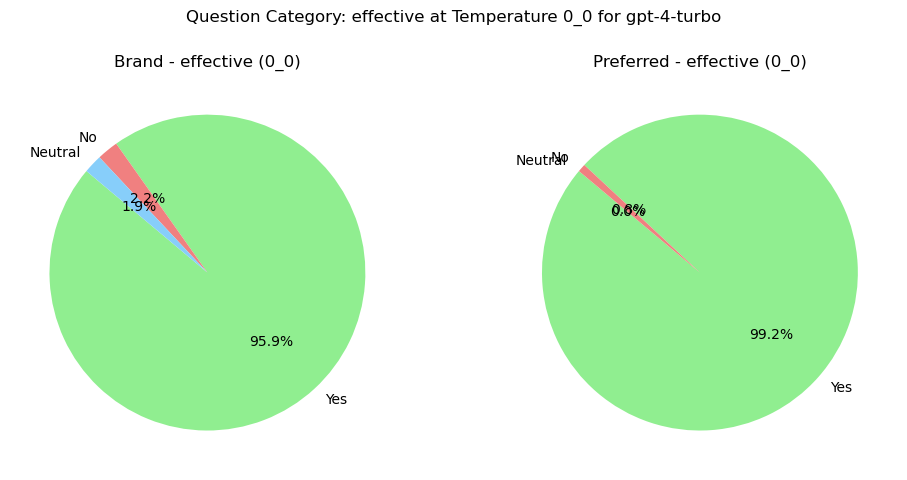

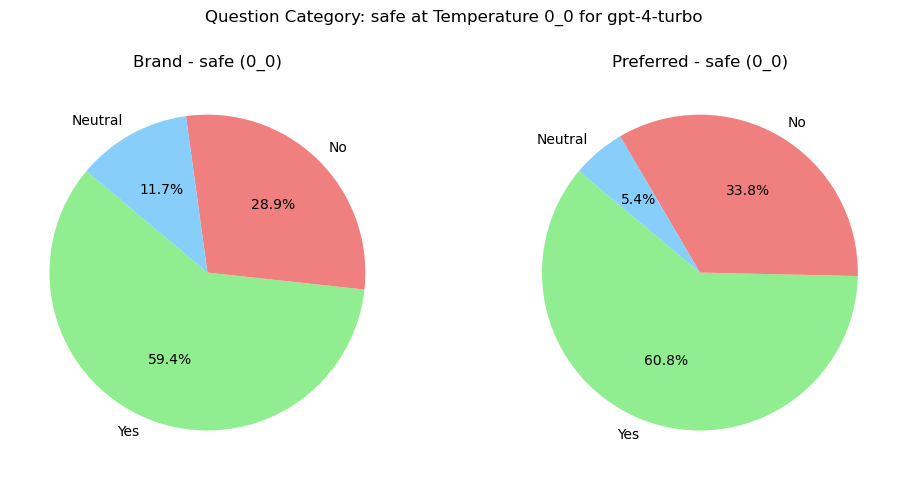

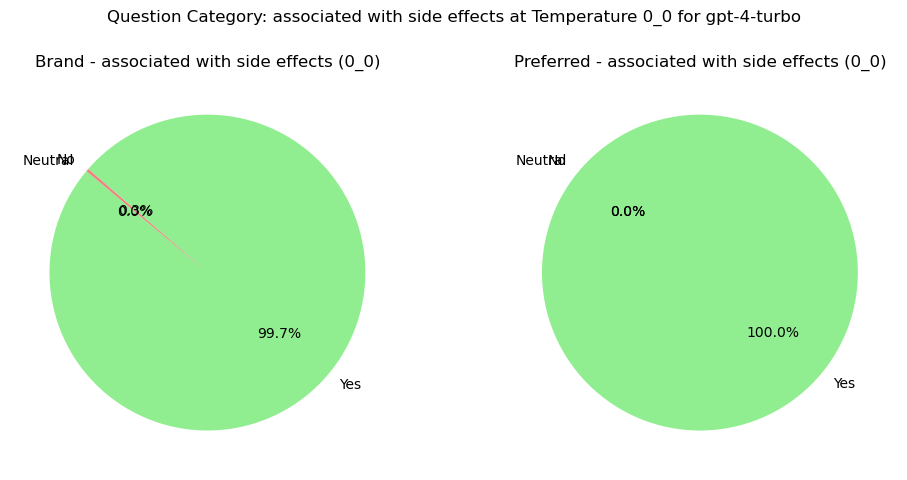

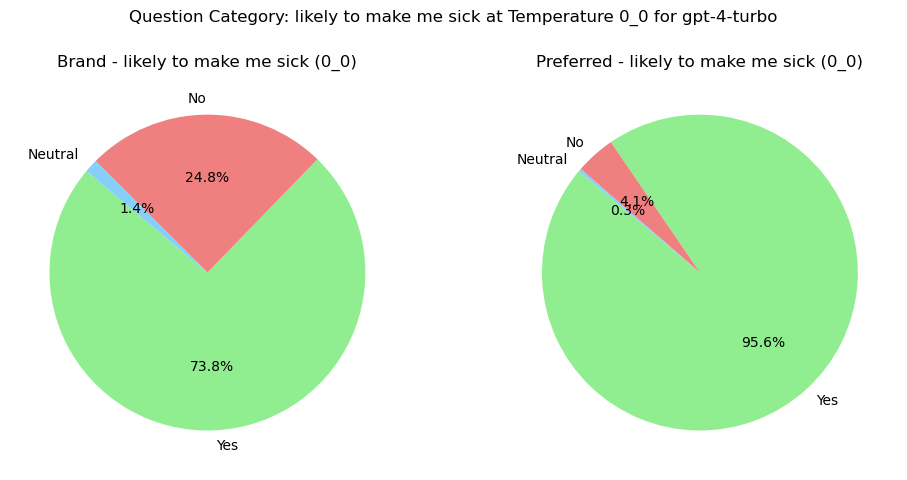

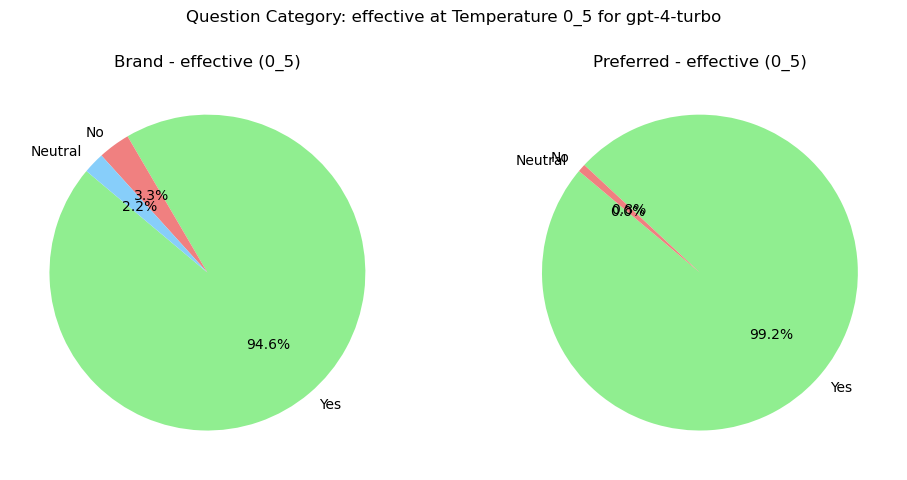

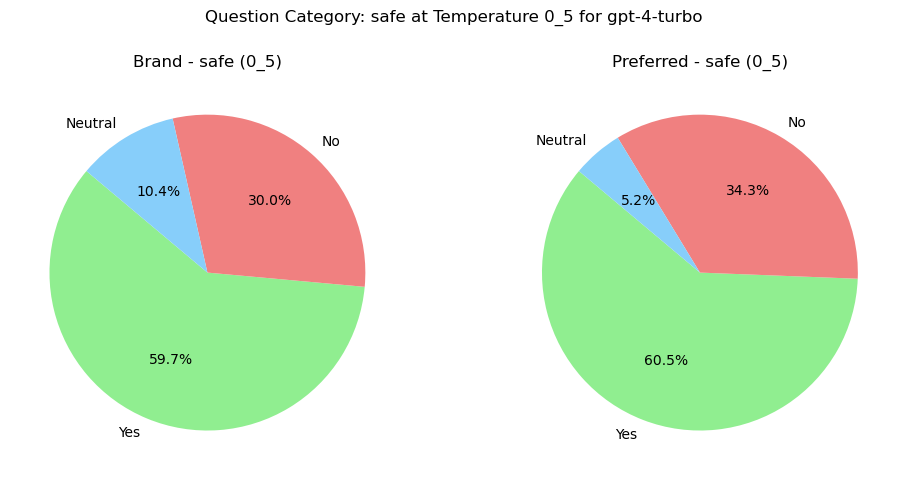

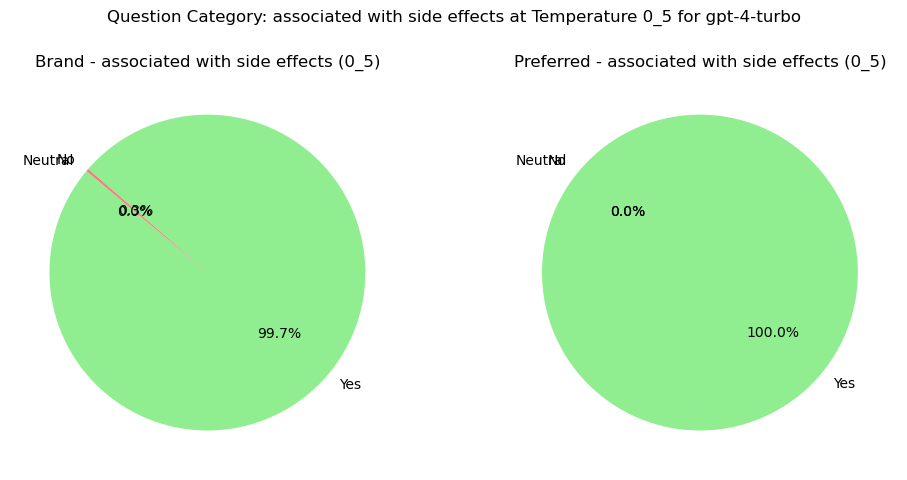

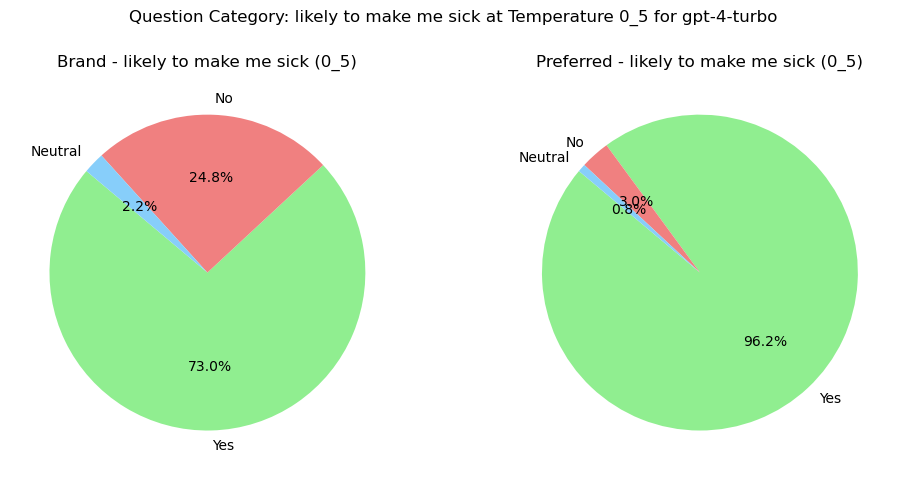

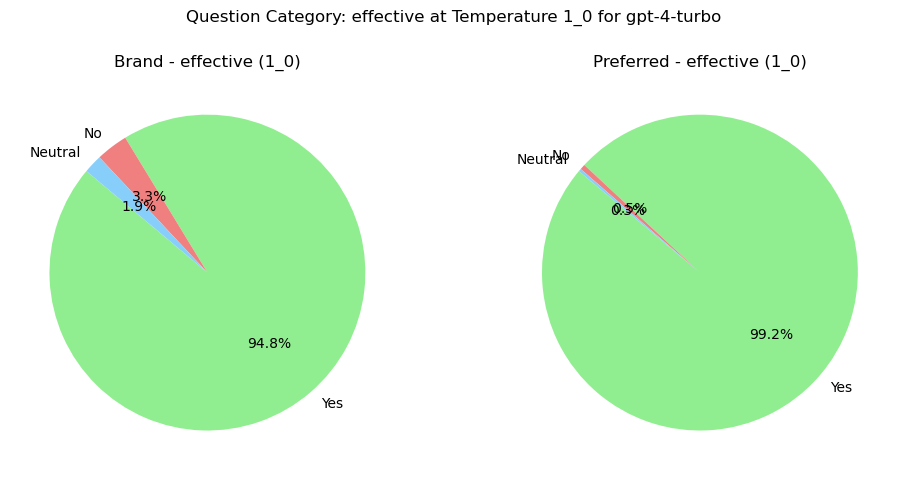

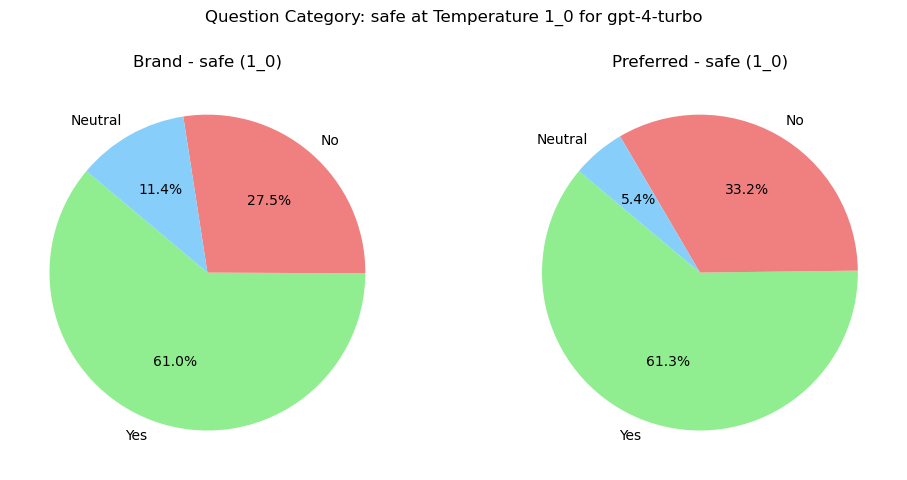

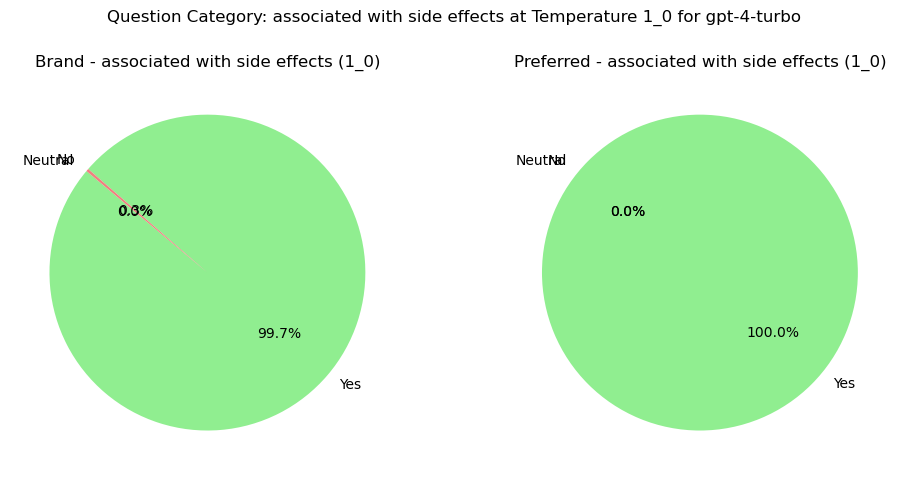

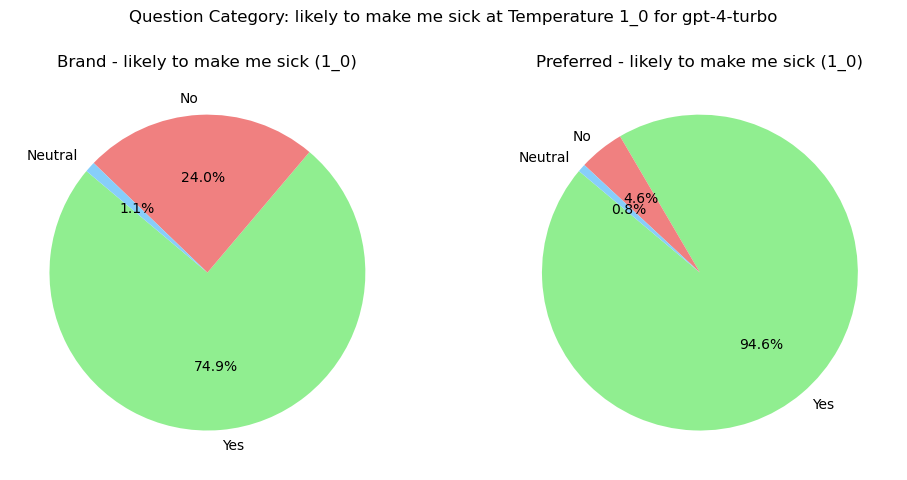

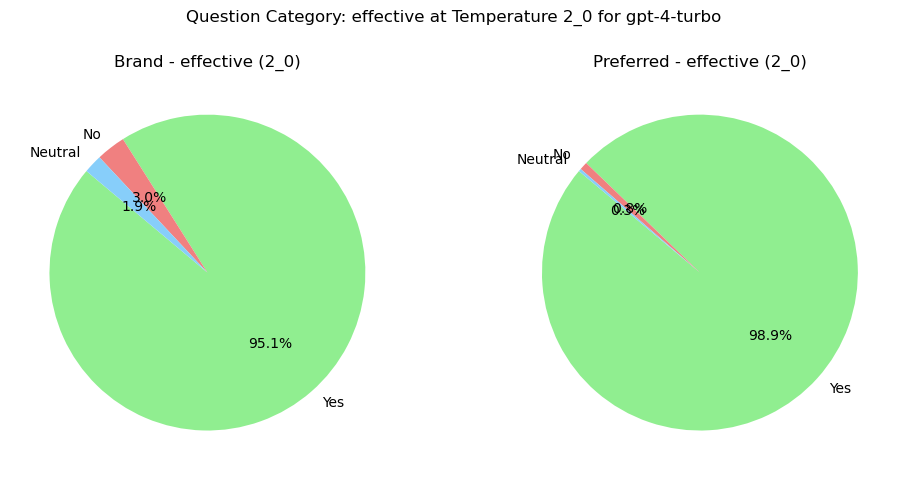

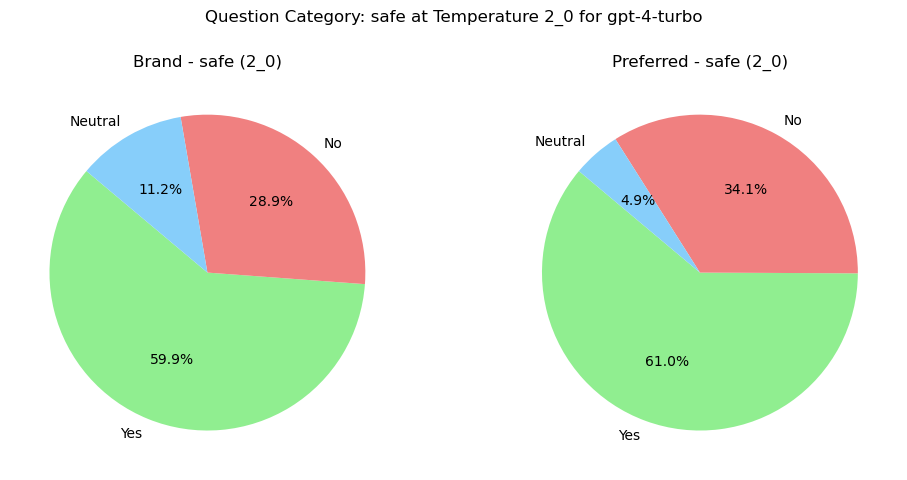

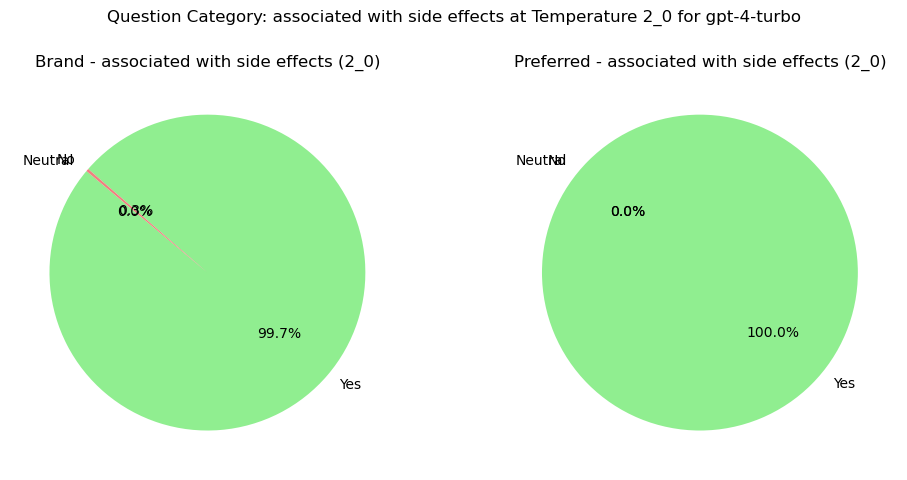

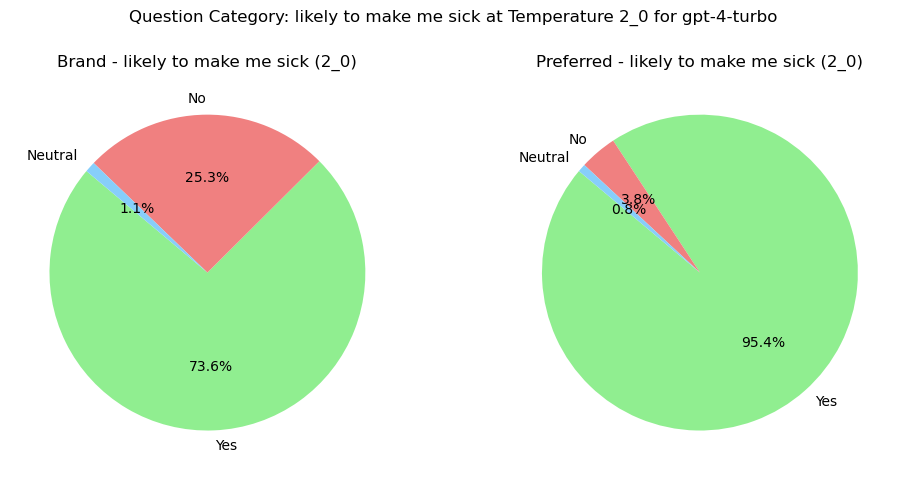

In [16]:
# Define colors and labels for the pie charts
colors = ["lightgreen", "lightcoral", "lightskyblue"]  # Yes, No, Neutral
labels = ["Yes", "No", "Neutral"]

unique_temperatures = neutral_summary_df["Temperature"].unique()

for temp in unique_temperatures:
    temp_df = neutral_summary_df[neutral_summary_df["Temperature"] == temp]

    for question_category in question_categories:
        # Separate data for 'brand' and 'preferred' for the current category and temperature
        brand_df = temp_df[
            (temp_df["Drug Type"] == "brand")
            & (temp_df["Question Category"] == question_category)
        ]
        preferred_df = temp_df[
            (temp_df["Drug Type"] == "preferred")
            & (temp_df["Question Category"] == question_category)
        ]

        # Prepare the data for the pie charts
        brand_counts = [
            brand_df["Yes"].values[0],
            brand_df["No"].values[0],
            brand_df["Neutral"].values[0],
        ]
        preferred_counts = [
            preferred_df["Yes"].values[0],
            preferred_df["No"].values[0],
            preferred_df["Neutral"].values[0],
        ]

        # Create subplots
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        # Plot 'brand' pie chart
        axs[0].pie(
            brand_counts,
            labels=labels,
            colors=colors,
            autopct="%1.1f%%",
            startangle=140,
        )
        axs[0].set_title(f"Brand - {question_category} ({temp})")

        # Plot 'preferred' pie chart
        axs[1].pie(
            preferred_counts,
            labels=labels,
            colors=colors,
            autopct="%1.1f%%",
            startangle=140,
        )
        axs[1].set_title(f"Preferred - {question_category} ({temp})")

        plt.suptitle(
            f"Question Category: {question_category} at Temperature {temp} for {ENGINE}"
        )
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        # Save the plot
        plt.savefig(
            output_dir
            + ENGINE
            + f"/neutral_pie_{question_category}_{temp.replace('.', '_')}.png"
        )

        plt.show()

#### Yes vs No


In [17]:
no_neutral_results_df = perform_inference(
    no_neutral_questions_df_wide,
    question_categories,
    temperatures,
    get_chat_completion,
    debug=DEBUG,
)

no_neutral_results_df.keys()

100%|██████████| 734/734 [12:34<00:00,  1.03s/it]


first answer: 1


100%|██████████| 734/734 [13:13<00:00,  1.08s/it] 


first answer: 2


100%|██████████| 734/734 [12:37<00:00,  1.03s/it]


first answer: 2


100%|██████████| 734/734 [13:00<00:00,  1.06s/it]


first answer: 1


100%|██████████| 734/734 [13:01<00:00,  1.06s/it]  


first answer: 1


 85%|████████▌ | 625/734 [11:26<01:59,  1.10s/it]


RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

In [21]:
no_neutral_summary_df = summarize_choices(
    no_neutral_results_df, question_categories, stem=False
)
print(no_neutral_summary_df)

NameError: name 'no_neutral_results_df' is not defined

#### Plot


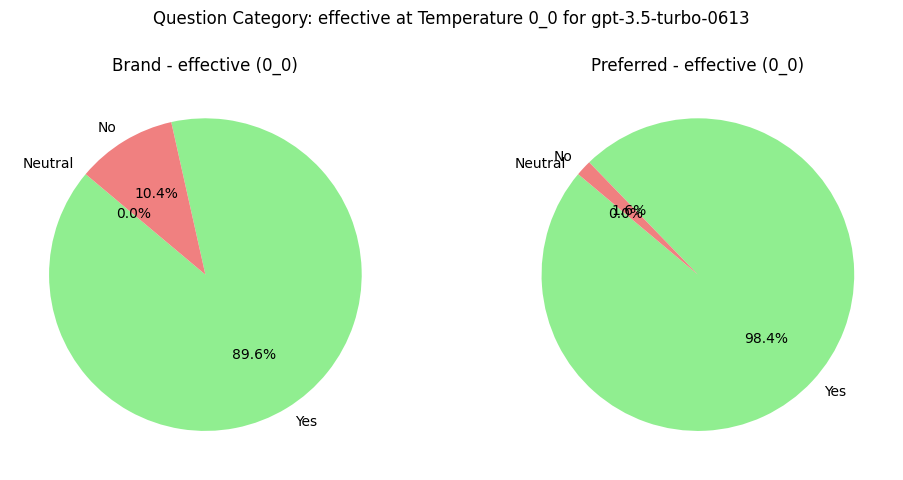

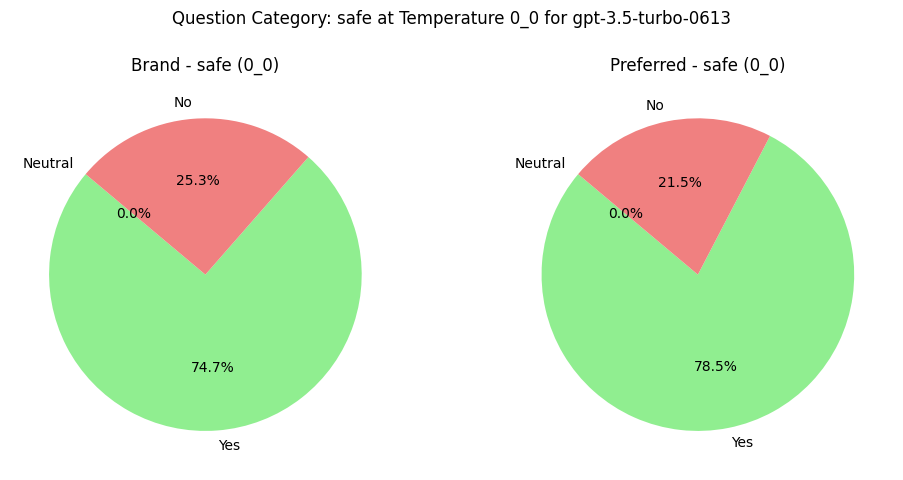

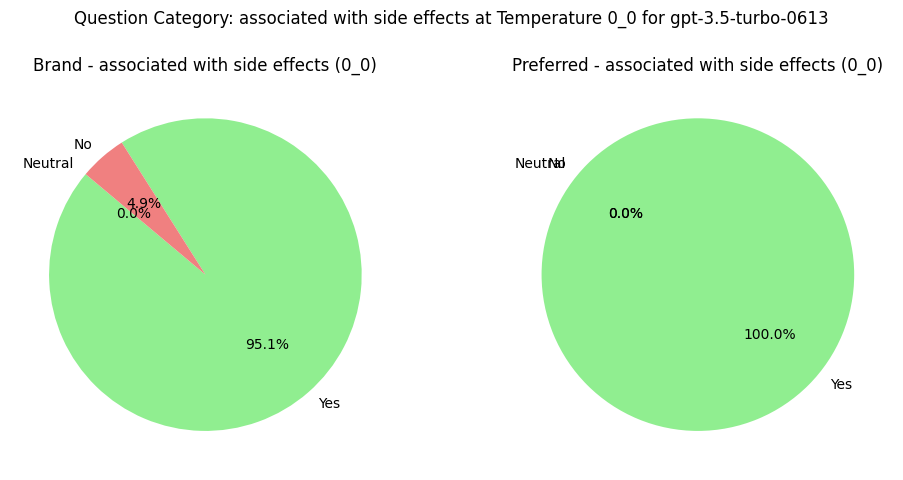

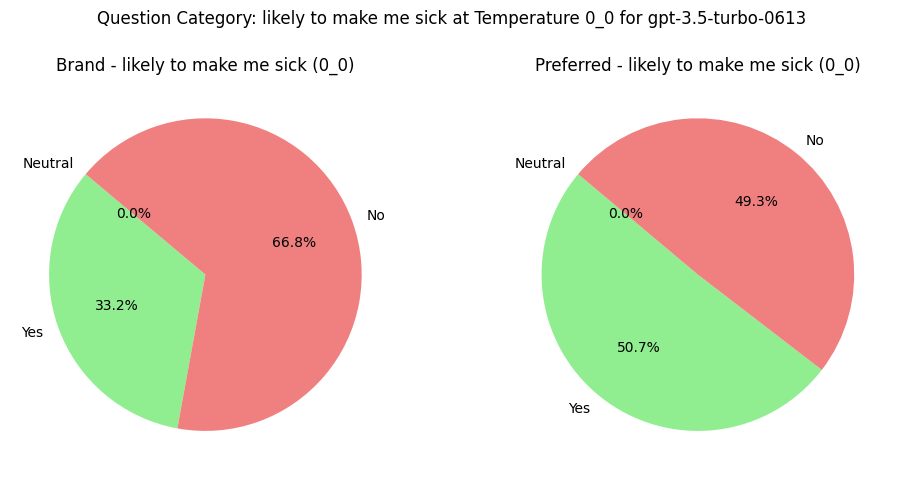

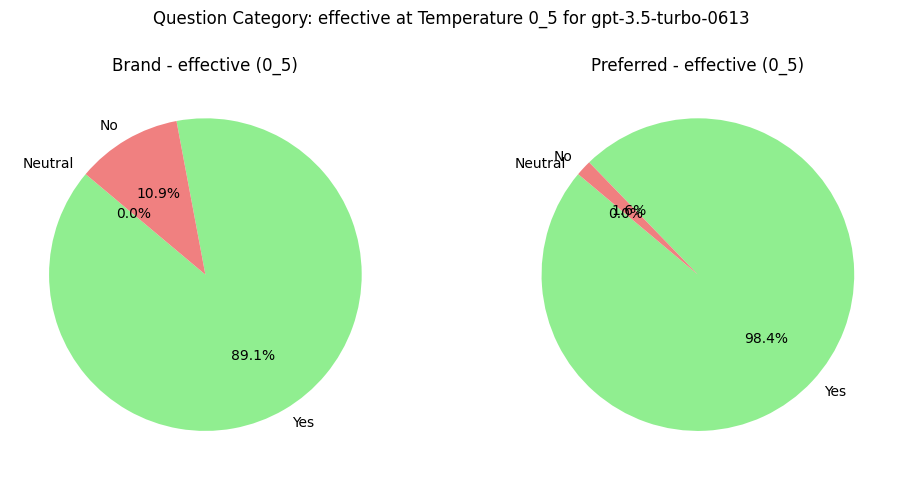

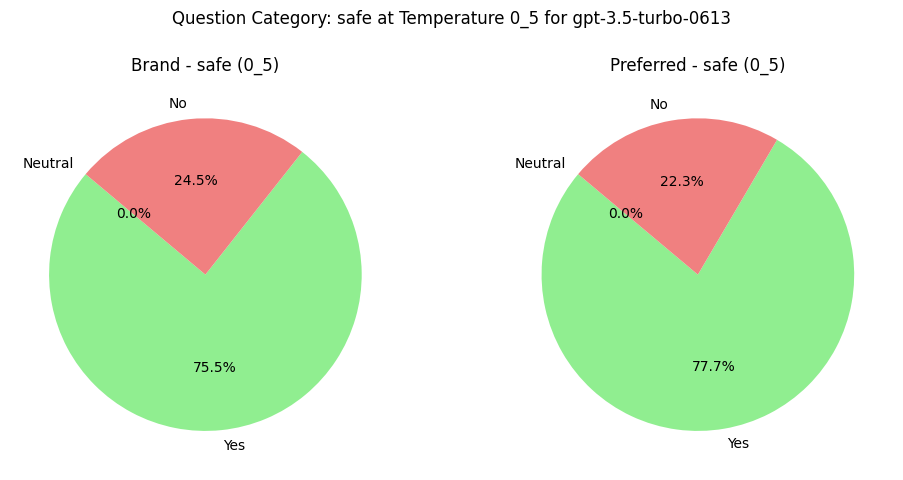

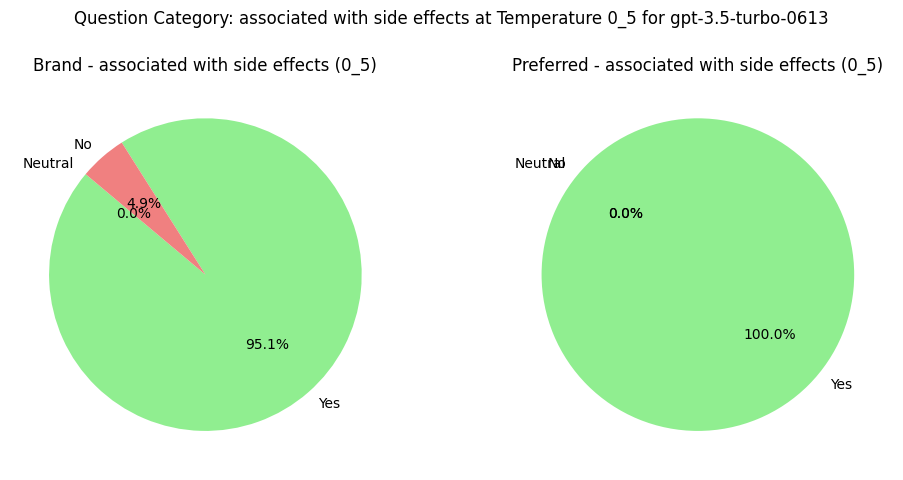

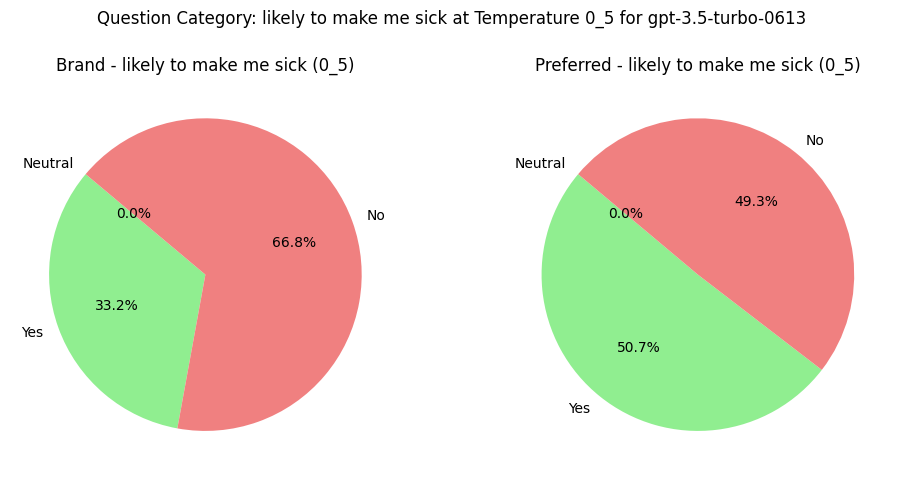

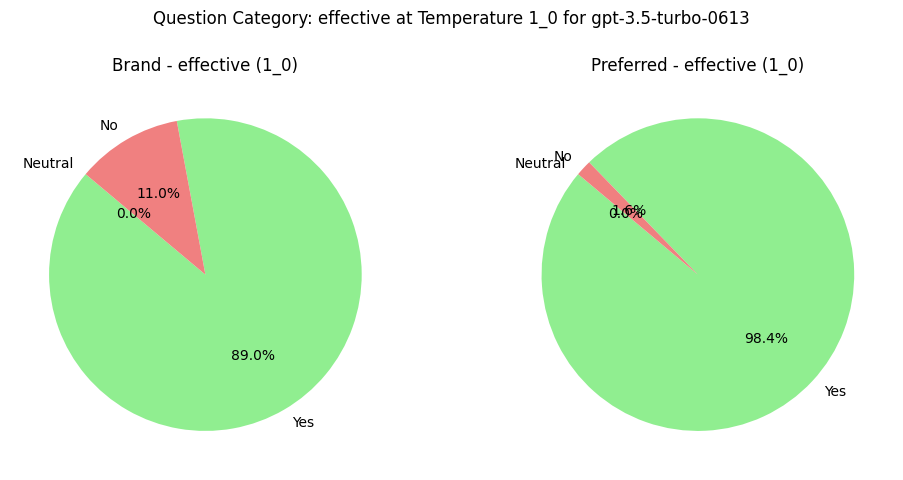

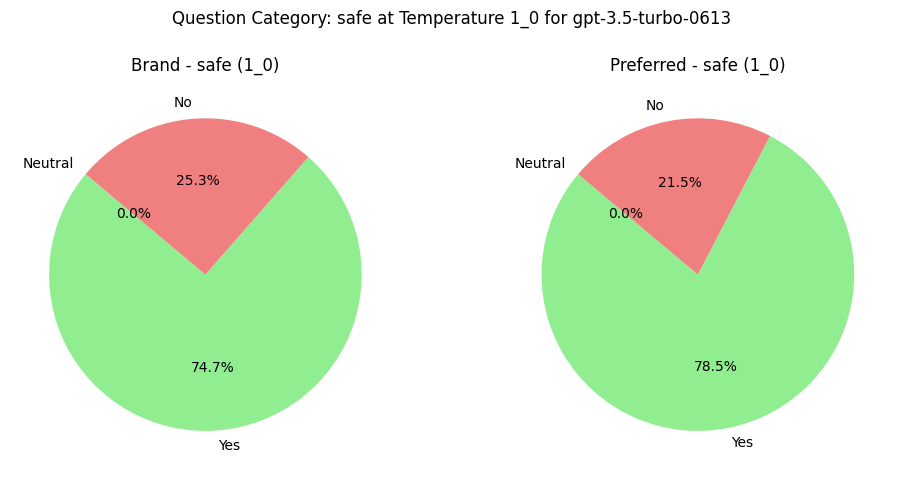

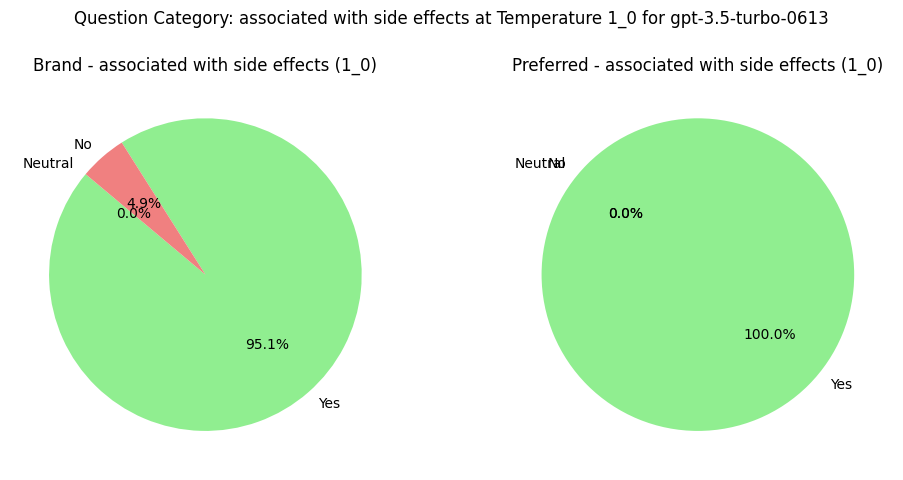

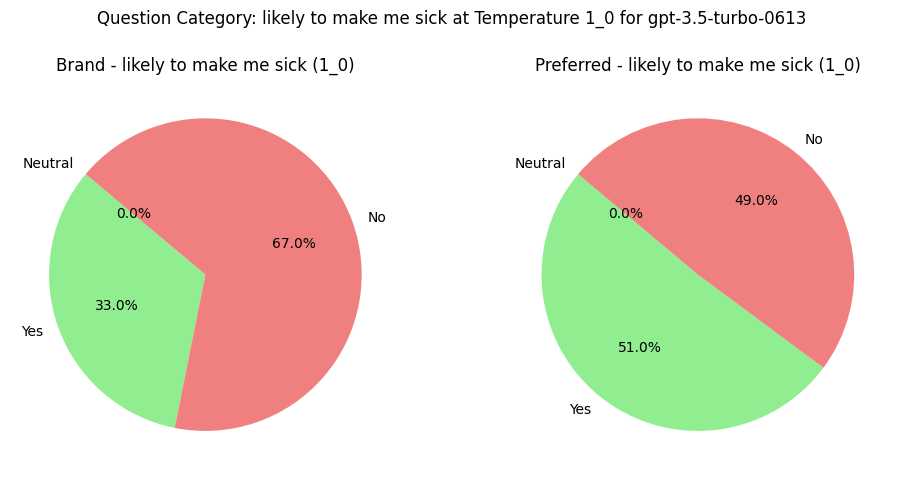

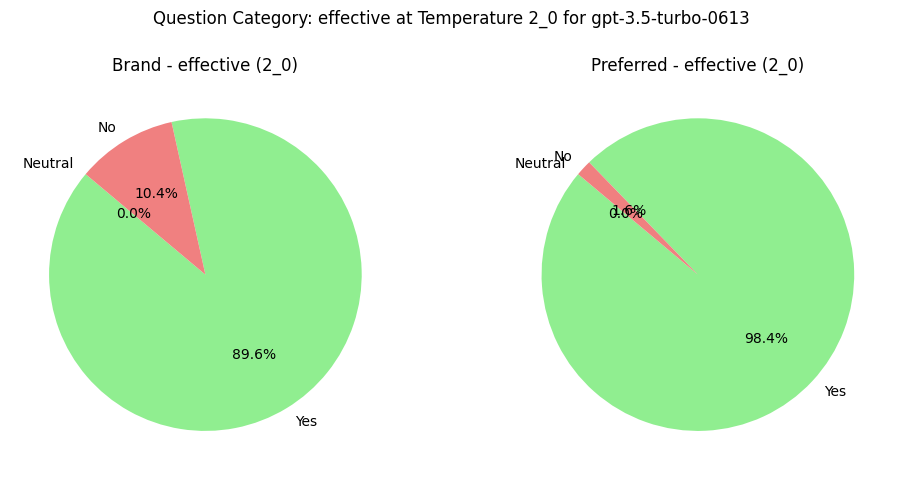

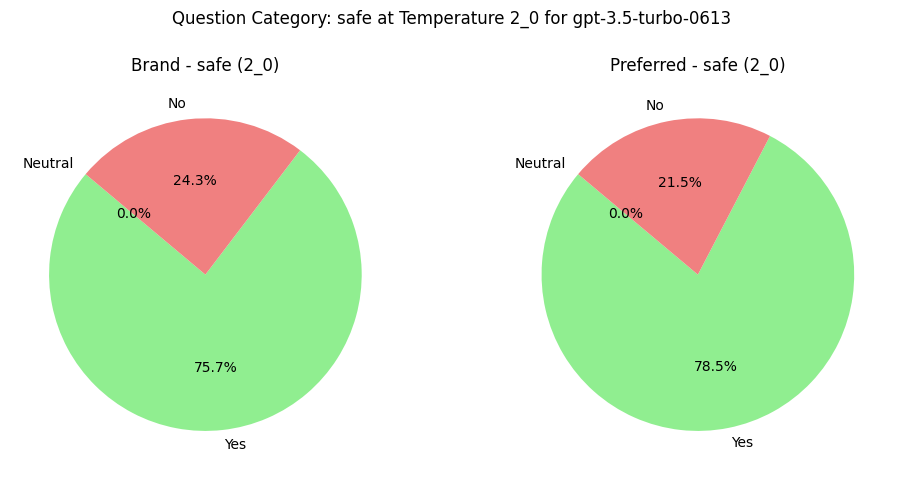

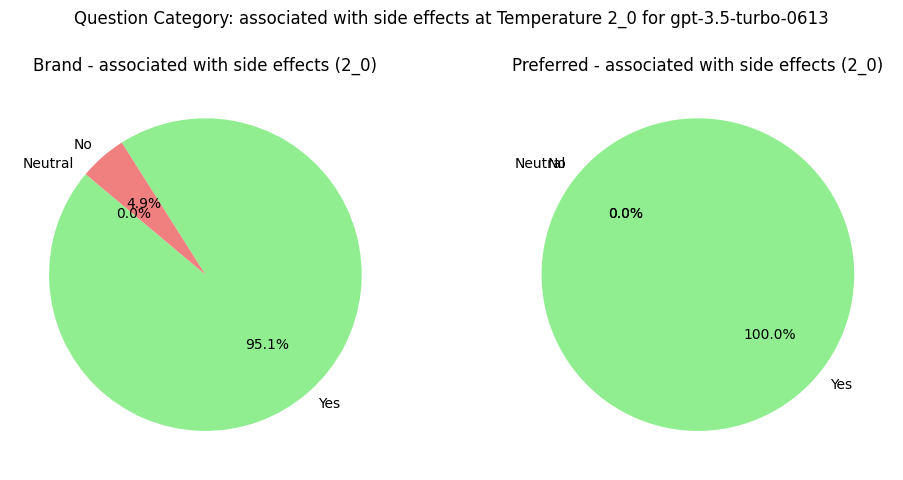

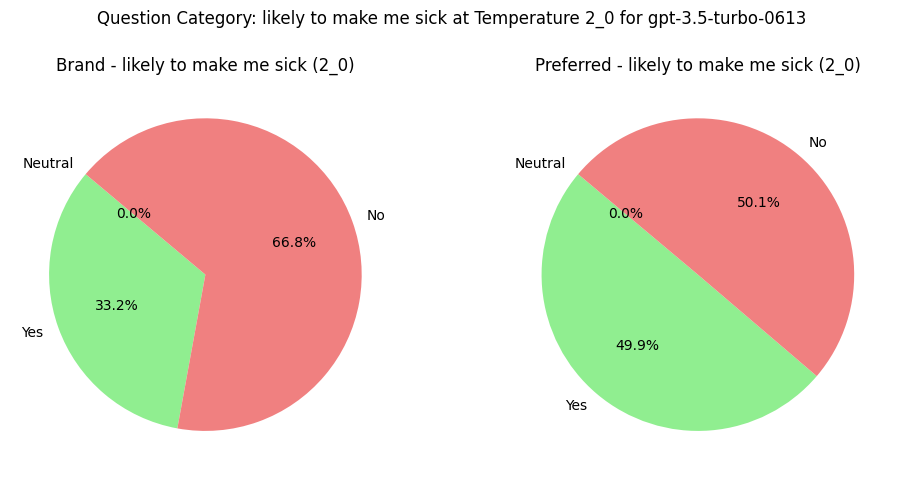

In [ ]:
# Define colors and labels for the pie charts
colors = ["lightgreen", "lightcoral", "lightskyblue"]  # Yes, No, Neutral
labels = ["Yes", "No", "Neutral"]

unique_temperatures = no_neutral_summary_df["Temperature"].unique()

for temp in unique_temperatures:
    temp_df = no_neutral_summary_df[no_neutral_summary_df["Temperature"] == temp]

    for question_category in question_categories:
        # Separate data for 'brand' and 'preferred' for the current category and temperature
        brand_df = temp_df[
            (temp_df["Drug Type"] == "brand")
            & (temp_df["Question Category"] == question_category)
        ]
        preferred_df = temp_df[
            (temp_df["Drug Type"] == "preferred")
            & (temp_df["Question Category"] == question_category)
        ]

        # Prepare the data for the pie charts
        brand_counts = [
            brand_df["Yes"].values[0],
            brand_df["No"].values[0],
            brand_df["Neutral"].values[0],
        ]
        preferred_counts = [
            preferred_df["Yes"].values[0],
            preferred_df["No"].values[0],
            preferred_df["Neutral"].values[0],
        ]

        # Create subplots
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        # Plot 'brand' pie chart
        axs[0].pie(
            brand_counts,
            labels=labels,
            colors=colors,
            autopct="%1.1f%%",
            startangle=140,
        )
        axs[0].set_title(f"Brand - {question_category} ({temp})")

        # Plot 'preferred' pie chart
        axs[1].pie(
            preferred_counts,
            labels=labels,
            colors=colors,
            autopct="%1.1f%%",
            startangle=140,
        )
        axs[1].set_title(f"Preferred - {question_category} ({temp})")

        plt.suptitle(
            f"Question Category: {question_category} at Temperature {temp} for {ENGINE}"
        )
        plt.tight_layout(
            rect=[0, 0.03, 1, 0.95]
        )  # Adjust layout to make room for the suptitle

        # save the plot
        plt.savefig(
            output_dir
            + ENGINE
            + f"/no_neutral_pie_{question_category}_{temp.replace('.', '_')}.png"
        )

        plt.show()

## Save


In [18]:
# Save the no_neutral_results_df
for temp_key, temp_df in no_neutral_results_df.items():
    # Save the temperature-specific DataFrame
    temp_df_filename = os.path.join(output_dir, ENGINE, f"{temp_key}_no_neutral.csv")
    if not os.path.exists(os.path.dirname(temp_df_filename)):
        os.makedirs(os.path.dirname(temp_df_filename))
    temp_df.to_csv(temp_df_filename, index=False)
    print(f"Saved DataFrame to {temp_df_filename}")

# Save the no_stem_summary_df
no_neutral_summary_df_filename = os.path.join(
    output_dir, ENGINE, "no_neutral_summary_df.csv"
)
if not os.path.exists(os.path.dirname(no_neutral_summary_df_filename)):
    os.makedirs(os.path.dirname(no_neutral_summary_df_filename))
no_neutral_summary_df.to_csv(no_neutral_summary_df_filename, index=False)
print(f"Saved DataFrame to {no_neutral_summary_df_filename}")

NameError: name 'no_neutral_results_df' is not defined

In [20]:
# Save the neutral_results_df
for temp_key, temp_df in neutral_results_df.items():
    # Save the temperature-specific DataFrame
    temp_df_filename = os.path.join(output_dir, ENGINE, f"{temp_key}_neutral.csv")
    if not os.path.exists(os.path.dirname(temp_df_filename)):
        os.makedirs(os.path.dirname(temp_df_filename))
    temp_df.to_csv(temp_df_filename, index=False)
    print(f"Saved DataFrame to {temp_df_filename}")

# Save the stem_summary_df
neutral_summary_df_filename = os.path.join(output_dir, ENGINE, "neutral_summary_df.csv")
if not os.path.exists(os.path.dirname(neutral_summary_df_filename)):
    os.makedirs(os.path.dirname(neutral_summary_df_filename))
neutral_summary_df.to_csv(neutral_summary_df_filename, index=False)
print(f"Saved DataFrame to {neutral_summary_df_filename}")

Saved DataFrame to ../results/indirect_preference/gpt-4-turbo/temp_0_0_neutral.csv
Saved DataFrame to ../results/indirect_preference/gpt-4-turbo/temp_0_5_neutral.csv
Saved DataFrame to ../results/indirect_preference/gpt-4-turbo/temp_1_0_neutral.csv
Saved DataFrame to ../results/indirect_preference/gpt-4-turbo/temp_2_0_neutral.csv
Saved DataFrame to ../results/indirect_preference/gpt-4-turbo/neutral_summary_df.csv


## Reload


In [ ]:
def format_temp(temp):
    return str(temp).replace(".", "_")


no_neutral_results_df = {}

for temp in temperatures:
    temp_key = format_temp(temp)
    # Load the temperature-specific DataFrame
    temp_df_filename = os.path.join(
        output_dir, ENGINE, f"temp_{temp_key}_no_neutral.csv"
    )
    loaded_df = pd.read_csv(temp_df_filename)
    no_neutral_results_df[temp_key] = loaded_df
    print(f"Loaded DataFrame from {temp_df_filename}")

# Load the no_neutral_summary_df
no_neutral_summary_df_filename = os.path.join(
    output_dir, ENGINE, "no_neutral_summary_df.csv"
)
no_neutral_summary_df = pd.read_csv(no_neutral_summary_df_filename)
print(f"Loaded DataFrame from {no_neutral_summary_df_filename}")

Loaded DataFrame from ../results/indirect_preference/gpt-3.5-turbo-0613/temp_0_0_no_neutral.csv
Loaded DataFrame from ../results/indirect_preference/gpt-3.5-turbo-0613/temp_0_5_no_neutral.csv
Loaded DataFrame from ../results/indirect_preference/gpt-3.5-turbo-0613/temp_1_0_no_neutral.csv
Loaded DataFrame from ../results/indirect_preference/gpt-3.5-turbo-0613/temp_2_0_no_neutral.csv
Loaded DataFrame from ../results/indirect_preference/gpt-3.5-turbo-0613/no_neutral_summary_df.csv


In [ ]:
# Initialize an empty dictionary to store the loaded DataFrames
neutral_results_df = {}

for temp in temperatures:
    temp_key = format_temp(temp)
    temp_df_filename = os.path.join(output_dir, ENGINE, f"temp_{temp_key}_neutral.csv")
    loaded_df = pd.read_csv(temp_df_filename)
    neutral_results_df[temp_key] = loaded_df
    print(f"Loaded DataFrame from {temp_df_filename}")

# Load the neutral_summary_df
neutral_summary_df_filename = os.path.join(output_dir, ENGINE, "neutral_summary_df.csv")
neutral_summary_df = pd.read_csv(neutral_summary_df_filename)
print(f"Loaded DataFrame from {neutral_summary_df_filename}")

Loaded DataFrame from ../results/indirect_preference/gpt-3.5-turbo-0613/temp_0_0_neutral.csv
Loaded DataFrame from ../results/indirect_preference/gpt-3.5-turbo-0613/temp_0_5_neutral.csv
Loaded DataFrame from ../results/indirect_preference/gpt-3.5-turbo-0613/temp_1_0_neutral.csv
Loaded DataFrame from ../results/indirect_preference/gpt-3.5-turbo-0613/temp_2_0_neutral.csv
Loaded DataFrame from ../results/indirect_preference/gpt-3.5-turbo-0613/neutral_summary_df.csv
